In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from ASLDataset import ASLDataset
import torch.optim as optim
import time
from torchsummary import summary
import torchvision.models as models
from torchvision.io import read_image
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 29)
resnet.load_state_dict(torch.load('./trained_models/resnet_raw.pth', map_location=torch.device('cpu')))
resnet.eval()
resnet.to(device)
print(device)

summary(resnet,(3, 200, 200))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1

In [26]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Resize((224, 224)),
#      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
# )

# image = imread('./imgs/shadow_removal_image_S2503.jpg')
# image = transform(image)
# image = image.to(device).unsqueeze(0)

# print(image.shape)


In [27]:
# output = resnet(image)
# _, predicted = torch.max(output.data, 1)
# softmax = nn.Softmax(dim=1)
# print(output)
# print(F.softmax(output, dim=1))
# print(predicted.item())

In [28]:
def test(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    y = []
    y_pre = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            y_pre.extend(predicted.tolist())
            y.extend(labels.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct/total, y, y_pre

def draw_cm(y, y_pre):
    labels = np.unique(y)
    cm = confusion_matrix(y, y_pre, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()


In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

['E', 'S']
0 E
1 S


/home/sam/anaconda3/envs/test/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


0.5044543429844098


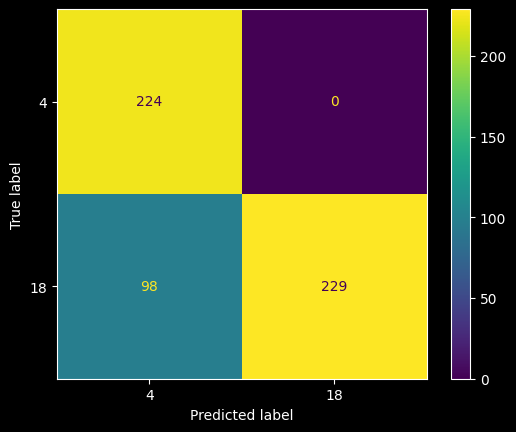

In [33]:
testset = ASLDataset('test',transform=transform, classes=['E', 'S'], ranges=[[2551, 3000], [2551, 3000]])

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

acc, y, y_pre = test(resnet, testloader)

print(acc)
draw_cm(y, y_pre)

In [34]:
# testset_noshadow = ASLDataset('test',transform=transform, classes=['E', 'S'], ranges=[[1401, 1750], [1, 350]])

# testloader_noshadow = torch.utils.data.DataLoader(testset_noshadow, batch_size=64, shuffle=False, num_workers=1)

# acc, y, y_pre = test(resnet, testloader_noshadow)

# print(acc)
# draw_cm(y, y_pre)

['E', 'S']
0 E
1 S


/home/sam/anaconda3/envs/test/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


0.2516703786191537


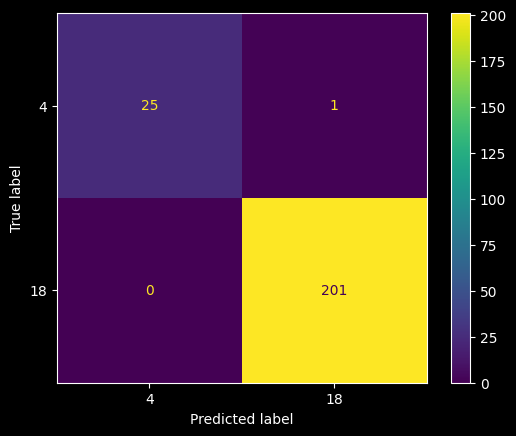

In [35]:
testset_noshadow = ASLDataset('test', preprocess=True, transform=transform, classes=['E', 'S'], ranges=[[2551, 3000], [2551, 3000]])

testloader_noshadow = torch.utils.data.DataLoader(testset_noshadow, batch_size=64, shuffle=False, num_workers=1)

acc, y, y_pre = test(resnet, testloader_noshadow)

print(acc)
draw_cm(y, y_pre)